In [1]:
import os, cv2, random, pickle
from tqdm import tqdm
import numpy as np
import pandas as pd

from urllib.request import urlretrieve
from os.path import isfile, isdir
import utils
from utils import *
import tarfile

import matplotlib.pyplot as plt
from matplotlib import ticker
%matplotlib inline

from keras.layers import Input, Dropout, Flatten, Dense, Activation, GlobalAveragePooling2D
from keras.optimizers import RMSprop,Nadam,SGD,Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, CSVLogger, LearningRateScheduler, ReduceLROnPlateau
from keras.utils import np_utils
from keras.models import load_model

from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import PReLU, ELU

from keras.applications.vgg16 import VGG16
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50, preprocess_input
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras import layers

import csv
import shutil

from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [5]:
# 创建目录

import os
import shutil


TTRAIN_DIR = './input/train/'
train_images = os.listdir(TTRAIN_DIR)
train_cats = [file for file in train_images if 'cat' in file]
train_dogs = [file for file in train_images if 'dog' in file]

TEST_DIR = './input/test/'
test_images = [file for file in os.listdir(TEST_DIR)]

def mkdir(path):
 
    isExists=os.path.exists(path)
 
    if not isExists:
        os.makedirs(path) 
 
        print(':{} 创建成功'.format(path))
        return True
    else:
        print(':{} 目录已存在'.format(path))
        return False
 
# 定义要创建的目录
mkpath_list=['./mydata1/', './mydata1/train/', './mydata1/train/cats/', 
             './mydata1/train/dogs/', './mydata1/validation/', './mydata1/test1/', './mydata1/test1/test/']

for path in mkpath_list:
    mkdir(path)

:./mydata1/ 创建成功
:./mydata1/train/ 创建成功
:./mydata1/train/cats/ 创建成功
:./mydata1/train/dogs/ 创建成功
:./mydata1/validation/ 创建成功
:./mydata1/test1/ 创建成功
:./mydata1/test1/test/ 创建成功


In [6]:
def copyfile(path, str, new_path):
    i = 0
    for file in path:
        if str in file:
            shutil.copy(file, new_path)
            i = i+1
    print('copyed {} {} images to {}'.format(i, str, new_path))

In [7]:
def copyfileno(path, new_path):
    i = 0
    for file in path:
        shutil.copy(file, new_path)
        i = i+1
    print('copyed {} images to {}'.format(i, new_path))

In [9]:
TRAIN_DIR = './input/train/'
train_images = [TRAIN_DIR + file for file in os.listdir(TTRAIN_DIR)]

TEST_DIR = './input/test/'
test_images = [TEST_DIR + file for file in os.listdir(TEST_DIR)]

TRAIN_SUP_DIR = './input/images/'
train_sup_images = [TRAIN_SUP_DIR + file for file in os.listdir(TRAIN_SUP_DIR)]

# copyfile(train_images, 'dog', './mydata1/train/dogs/')
# copyfile(train_images, 'cat', './mydata1/train/cats/')
copyfile(train_sup_images, 'dog', './mydata1/train/dogs/')
copyfile(train_sup_images, 'cat', './mydata1/train/cats/')
copyfileno(test_images, './mydata1/test1/test/')

copyed 4990 dog images to ./mydata1/train/dogs/
copyed 2400 cat images to ./mydata1/train/cats/
copyed 12500 images to ./mydata1/test1/test/


In [13]:
ab_img_list = []

csv_file = csv.reader(open('relabel.csv'))
for filename in csv_file:
    if 'dog' in filename[1] or 'cat' in filename[1]:
        if '.jpg' not in filename[1]:
            filename = filename[1] + '.jpg'
            ab_img_list.append(filename)
        else:
            ab_img_list.append(filename[1]) 
            
#删除异常图片文件--50张

for file in os.listdir('./mydata1/train/dogs/'):
    if file in ab_img_list:
        os.remove('./mydata1/train/dogs/' + file)
        print(file)

for file in os.listdir('./mydata1/train/cats/'):
    if file in ab_img_list:
        os.remove('./mydata1/train/cats/' + file)
        print(file)

In [16]:
#删除补充数据集中无法读取的异常图片
TRAIN_DIR_SUP_1 = './input/images/'
train_images_path_sup = [TRAIN_DIR_SUP_1+i for i in os.listdir(TRAIN_DIR_SUP_1)] 

# height = []
# width = []

none_img_list=[]

for file in train_images_path_sup:
    image = cv2.imread(file)
    if np.any(image == None):
        none_img_list.append(file)
        print(file)

./input/images/cat_5597.jpg
./input/images/cat_1399.jpg
./input/images/cat_4197.jpg
./input/images/cat_5760.jpg
./input/images/cat_7252.jpg
./input/images/cat_2717.jpg


In [17]:
file_list = []
for path in none_img_list:
    index = path.rfind('/')
    file = path[index+1:]
    file_list.append(file)


In [18]:
file_list

['cat_5597.jpg',
 'cat_1399.jpg',
 'cat_4197.jpg',
 'cat_5760.jpg',
 'cat_7252.jpg',
 'cat_2717.jpg']

In [19]:
#删除异常图片文件--6张

for file in os.listdir('./mydata1/train/cats/'):
    if file in file_list:
        os.remove('./mydata1/train/cats/' + file)
        print(file)

cat_5597.jpg
cat_1399.jpg
cat_4197.jpg
cat_5760.jpg
cat_7252.jpg
cat_2717.jpg


In [80]:
from keras.models import *
from keras.layers import *
from keras.applications import *
from keras.preprocessing.image import *

import h5py

def write_gap(MODEL, image_size, lambda_func=None):
    width = image_size[0]
    height = image_size[1]
    input_tensor = Input((height, width, 3))
    x = input_tensor
    if lambda_func:
        x = Lambda(lambda_func)(x)
    
    base_model = MODEL(input_tensor=x, weights='imagenet', include_top=False)
    model = Model(base_model.input, GlobalAveragePooling2D()(base_model.output))

    gen = ImageDataGenerator()
    train_generator = gen.flow_from_directory("./mydata1/train", image_size, shuffle=False, 
                                              batch_size=16)
    test_generator = gen.flow_from_directory("./mydata1/test1", image_size, shuffle=False, 
                                             batch_size=16, class_mode=None)

    train = model.predict_generator(train_generator, verbose=1)
    test = model.predict_generator(test_generator, verbose=1)
    with h5py.File('fv_{}_{}.h5'.format(MODEL.__name__, width)) as h:
        h.create_dataset("train", data=train)
        h.create_dataset("test", data=test)
        h.create_dataset("label", data=train_generator.classes)

In [21]:
write_gap(VGG16, (224, 224))
write_gap(ResNet50, (224, 224))
write_gap(InceptionV3, (299, 299), inception_v3.preprocess_input)
write_gap(Xception, (299, 299), xception.preprocess_input)

Found 32334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 70s 89ms/step
Found 32334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 70s 90ms/step
Found 32334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 80s 102ms/step
Found 32334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 77s 99ms/step


In [81]:
write_gap(VGG16, (350, 350))
write_gap(ResNet50, (350, 350))
write_gap(InceptionV3, (350, 350), inception_v3.preprocess_input)
write_gap(Xception, (350, 350), xception.preprocess_input)

Found 32334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 82s 105ms/step
Found 32334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 85s 109ms/step
Found 32334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 82s 105ms/step
Found 32334 images belonging to 2 classes.
Found 12500 images belonging to 1 classes.
782/782 [==============================] - 87s 111ms/step


In [66]:
import h5py
import numpy as np
from sklearn.utils import shuffle
np.random.seed(2018)

X_train = []
X_test = []

for filename in ["fv_ResNet50_350.h5", "fv_Xception_350.h5", "fv_InceptionV3_350.h5"]:
    with h5py.File(filename, 'r') as h:
        X_train.append(np.array(h['train']))
        X_test.append(np.array(h['test']))
        y_train = np.array(h['label'])

X_train = np.concatenate(X_train, axis=1)
X_test = np.concatenate(X_test, axis=1)

# X_train, y_train = shuffle(X_train, y_train)

In [47]:
# model.fit(X_train, y_train, batch_size=128, nb_epoch=8, validation_split=0.2, shuffle=True)

In [69]:
from keras.models import *
from keras.layers import *

np.random.seed(2018)

optimizer = Nadam(lr=0.0005)
# optimizer = 'adadelta'
# optimizer = RMSprop(lr=1e-4)
# optimizer=SGD(0.001, momentum=0.9, nesterov=True)

#原始
# input_tensor = Input(X_train.shape[1:])
# dropout = Dropout(0.5)(input_tensor)
# output = Dense(1, activation='sigmoid')(dropout)


#调整，针对原始尺寸，最高0.00552
input_tensor = Input(X_train.shape[1:])
dense = Dense(512)(input_tensor)
batchnormed = BatchNormalization()(dense)
relu = ELU()(batchnormed)
dropout = Dropout(0.01)(relu)
output = Dense(1, activation='sigmoid')(dropout)


model = Model(input_tensor, output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [79]:
from keras.models import *
from keras.layers import *

np.random.seed(2018)

optimizer = Nadam(lr=0.0005)
# optimizer = 'adadelta'
# optimizer = RMSprop(lr=1e-4)
# optimizer=SGD(0.001, momentum=0.9, nesterov=True)

#原始
# input_tensor = Input(X_train.shape[1:])
# dropout = Dropout(0.5)(input_tensor)
# output = Dense(1, activation='sigmoid')(dropout)


#调整，针对350尺寸，最高0.00328,0.9988
input_tensor = Input(X_train.shape[1:])
dense = Dense(512)(input_tensor)
batchnormed = BatchNormalization()(dense)
relu = ELU()(batchnormed)
dropout = Dropout(0.01)(relu)
output = Dense(1, activation='sigmoid')(dropout)


model = Model(input_tensor, output)

model.compile(optimizer=optimizer,
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [80]:
# 模型训练

nb_epoch = 100
batch_size = 128

val_checkpoint = ModelCheckpoint('mix_bestval_{val_loss:.4f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
    
lrSchduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=4, verbose=1, mode='min')


        
def run_catdog():
    
    history = LossHistory()
    model.fit(X_train, y_train, batch_size=batch_size, epochs=nb_epoch, verbose=1, shuffle=True, 
              validation_split=0.2, callbacks=[history, early_stopping, val_checkpoint,lrSchduler])
    
    return history

history = run_catdog()

Train on 25867 samples, validate on 6467 samples
Epoch 1/100
25867/25867 [==============================] - 5s 176us/step - loss: 0.0275 - acc: 0.9900 - val_loss: 0.0223 - val_acc: 0.9920

Epoch 00001: val_loss improved from inf to 0.02232, saving model to mix_bestval_0.0223.h5
Epoch 2/100
25867/25867 [==============================] - 2s 90us/step - loss: 0.0068 - acc: 0.9974 - val_loss: 0.0529 - val_acc: 0.9841

Epoch 00002: val_loss did not improve from 0.02232
Epoch 3/100
25867/25867 [==============================] - 2s 91us/step - loss: 0.0038 - acc: 0.9989 - val_loss: 0.6262 - val_acc: 0.8245

Epoch 00003: val_loss did not improve from 0.02232

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 4/100
25867/25867 [==============================] - 2s 90us/step - loss: 0.0062 - acc: 0.9980 - val_loss: 0.0109 - val_acc: 0.9963

Epoch 00004: val_loss improved from 0.02232 to 0.01087, saving model to mix_bestval_0.0109.h5
Epoch 5/100
25867/25867 [==

In [96]:
model = load_model('mix_bestval_0.0062.h5')

In [97]:
predictions = model.predict(X_test, verbose=1)

12500/12500 [==============================] - 2s 146us/step


In [98]:
pickle.dump(predictions, open('predictions_0.0062.p', 'wb'))
print('save data done!')

save data done!


In [66]:
predictions

array([[9.9984729e-01],
       [6.4735364e-06],
       [1.6646410e-04],
       ...,
       [9.9993026e-01],
       [7.8001540e-06],
       [2.0088177e-05]], dtype=float32)

In [49]:
def dog_probab(y):
    return [x[0] for x in y]

In [50]:
predictions = dog_probab(predictions)
predictions

[0.9998473,
 6.4735364e-06,
 0.0001664641,
 0.9999865,
 0.99998856,
 4.411383e-06,
 6.130781e-05,
 0.99979514,
 0.9981179,
 4.732776e-06,
 4.275537e-06,
 8.620804e-06,
 3.1629155e-05,
 0.0010176304,
 6.1981596e-06,
 0.9999571,
 0.9999746,
 2.5174093e-06,
 3.3619293e-05,
 3.4843593e-05,
 0.99994457,
 0.00066152937,
 0.00014524412,
 7.000089e-05,
 0.00015563886,
 0.9999896,
 4.863625e-06,
 2.392173e-05,
 0.9999491,
 0.99997807,
 0.9999006,
 0.9998398,
 0.9999926,
 0.99996984,
 1.4908693e-05,
 0.9952049,
 0.99999726,
 0.9999292,
 0.00031226286,
 2.4235625e-05,
 0.00010278319,
 0.9999231,
 0.9990288,
 0.99979967,
 0.049619097,
 0.9999528,
 0.9999932,
 0.9999912,
 5.5795203e-06,
 0.9998752,
 0.9995907,
 0.9999964,
 2.9120602e-06,
 0.99738306,
 0.99903095,
 0.9999893,
 0.99977916,
 3.3233011e-06,
 2.7835906e-06,
 0.0004358908,
 1.1283416e-05,
 2.64183e-06,
 0.99749964,
 0.00029716297,
 8.969524e-07,
 0.99997103,
 0.0009888202,
 0.99981624,
 0.9998043,
 0.99999595,
 0.9999666,
 0.0002463996,


In [34]:
gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("./mydata1/test1", (224, 224), 
                                         shuffle=False, batch_size=16, class_mode=None)

Found 12500 images belonging to 1 classes.


In [43]:
with open('sample_submission.csv','w') as f:
    f.write('id,label\n')
            
with open('sample_submission.csv','a') as f:
    num = len(predictions)
    pred = 0
    
    for i in tqdm(range(0,num)):
        
        f.write('{},{}\n'.format(i+1, pred))
        
f.close()
print('file closed!')

100%|██████████| 12500/12500 [00:00<00:00, 727208.17it/s]

file closed!


In [68]:
n = predictions[0]
n

array([0.9998473], dtype=float32)

In [74]:
df = pd.read_csv('sample_submission.csv')

y_pred = predictions.clip(min=0.005, max=0.995)

for i, file in enumerate(test_generator.filenames):
    index_1 = file.rfind('/')
    index_2 = file.rfind('.')
    file_index = int(file[index_1+1:index_2])
    df.set_value(file_index-1, 'label', y_pred[i])
    print(y_pred[i])
    print(df['label'][file_index-1])
    break
    
# df.to_csv('submission20.csv', index=None)

[0.995]
0


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead


In [75]:
df['label'][0]

0

In [56]:
df['label'][1]

1

In [52]:
df.head(10)

,id,label
0,1,0
1,2,0
2,3,0
3,4,0
4,5,0
5,6,0
6,7,0
7,8,0
8,9,0
9,10,0


In [42]:
df['id'][0]

1

In [ ]:
with open('submission18.csv','w') as f:
    f.write('id,label\n')
            
with open('submission18.csv','a') as f:
    num = len(predictions)
    pred = 0
    
    gen = ImageDataGenerator()
    test_generator = gen.flow_from_directory("./mydata1/test1", (224, 224), 
                                             shuffle=False, batch_size=16, class_mode=None)
    
    
    for i in tqdm(range(0,num)):
        pred = predictions[i, 0]
        
        f.write('{},{}\n'.format(i+1, pred))
        
f.close()
print('file closed!')

In [ ]:
y_pred = model.predict(X_test, verbose=1)
y_pred = y_pred.clip(min=0.005, max=0.995)

import pandas as pd
from keras.preprocessing.image import *

df = pd.read_csv("sample_submission.csv")

gen = ImageDataGenerator()
test_generator = gen.flow_from_directory("test2", (224, 224), shuffle=False, 
                                         batch_size=16, class_mode=None)

for i, fname in enumerate(test_generator.filenames):
    index = int(fname[fname.rfind('/')+1:fname.rfind('.')])
    df.set_value(index-1, 'label', y_pred[i])

df.to_csv('pred.csv', index=None)
df.head(10)

In [145]:
train_datagen = ImageDataGenerator(zoom_range=0.25, rotation_range=15., 
                             channel_shift_range=25. ,width_shift_range=0.02 ,height_shift_range=0.02, 
                             horizontal_flip=True, fill_mode='constant')

validation_datagen = ImageDataGenerator(horizontal_flip=True)

train_generator = datagen.flow_from_directory(
    train_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary')

validation_generator = datagen.flow_from_directory(
    validation_data_dir, 
    target_size=(img_width, img_height), 
    batch_size=batch_size, 
    class_mode='binary', shuffle=False)

Found 26390 images belonging to 2 classes.
Found 6000 images belonging to 2 classes.


In [2]:
# 下载Oxford-IIIT Pet Dataset补充数据集

image_supply_path = './input/images'

image_supply_loacation = './images.tar.gz'

if isfile(image_supply_loacation):
    tar_gz_path = image_supply_loacation
else:
    tar_gz_path = 'images.tar.gz'

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(tar_gz_path ):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='images supply dataset') as pbar:
        urlretrieve('http://www.robots.ox.ac.uk/%7Evgg/data/pets/data/images.tar.gz', tar_gz_path, pbar.hook)

if not isdir(image_supply_path):
    with tarfile.open(tar_gz_path) as tar:
        tar.extractall(path='./input/')
        tar.close()

test_folder_path(image_supply_path)

images supply dataset: 792MB [03:27, 3.81MB/s]                               


All files found!


In [3]:
# 修改补充数据集文件名，以dog.x和cat.x命名

trange_file_name('./input/images/')

7393it [00:00, 18996.16it/s]


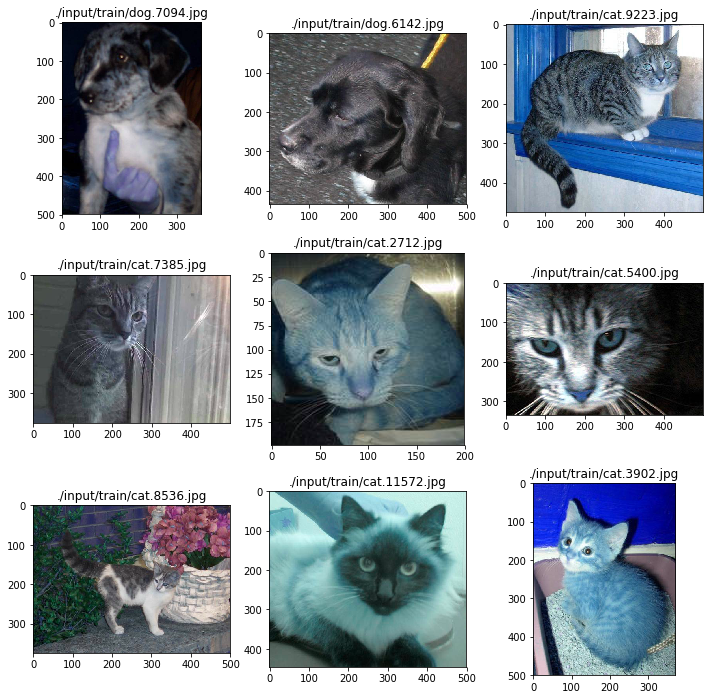

In [4]:
# 数据可视化

TRAIN_DIR = './input/train/'
train_images_path = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

# 随机展示9张图片

def random_show(location):
    plt.subplot(location)
    sample = random.choice(train_images_path)
    image = cv2.imread(sample)
    plt.title(sample)
    plt.imshow(image)
    
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for location in range(331, 340):
    random_show(location)
plt.show()

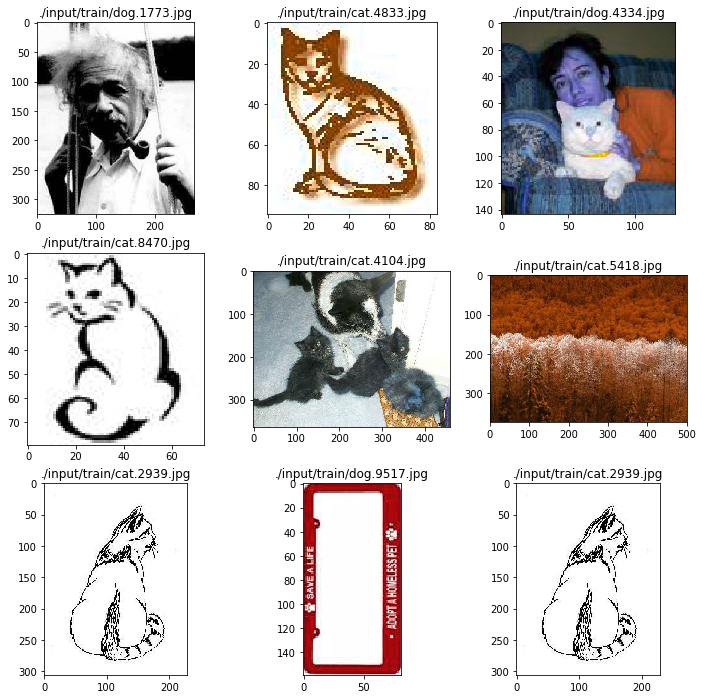

In [6]:
# 随机展示9张异常图片

ab_img_list = []

csv_file = csv.reader(open('relabel.csv'))
for filename in csv_file:
    if 'dog' in filename[1] or 'cat' in filename[1]:
        if '.jpg' not in filename[1]:
            filename = filename[1] + '.jpg'
            ab_img_list.append(filename)
        else:
            ab_img_list.append(filename[1])    
    else:
        pass

for i, file in enumerate(ab_img_list):
    ab_img_list[i] = './input/train/' + file
    
def random_show(location):
    plt.subplot(location)
    sample = random.choice(ab_img_list)
    image = cv2.imread(sample)
    plt.title(sample)
    plt.imshow(image)
    
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for location in range(331, 340):
    random_show(location)
plt.show()

In [2]:
# 删除训练集中异常的图片

TRAIN_DIR = './input/train/'
train_images_path = [TRAIN_DIR+i for i in os.listdir(TRAIN_DIR)]

ab_img_list = []

csv_file = csv.reader(open('relabel.csv'))
for filename in csv_file:
    if 'dog' in filename[1] or 'cat' in filename[1]:
        if '.jpg' not in filename[1]:
            filename = filename[1] + '.jpg'
            ab_img_list.append(filename)
        else:
            ab_img_list.append(filename[1])    
    else:
        pass

for i, file in enumerate(ab_img_list):
    ab_img_list[i] = './input/train/' + file

for file in train_images_path:
    if file in ab_img_list:
        train_images_path.remove(file)
        print(file)

./input/train/dog.1194.jpg
./input/train/dog.1043.jpg
./input/train/cat.2159.jpg
./input/train/cat.9171.jpg
./input/train/cat.5418.jpg
./input/train/cat.7194.jpg
./input/train/cat.4688.jpg
./input/train/cat.7564.jpg
./input/train/dog.8507.jpg
./input/train/dog.4334.jpg
./input/train/cat.2939.jpg
./input/train/cat.5351.jpg
./input/train/cat.7377.jpg
./input/train/dog.9517.jpg
./input/train/cat.3822.jpg
./input/train/dog.10237.jpg
./input/train/dog.11186.jpg
./input/train/dog.9188.jpg
./input/train/cat.4104.jpg
./input/train/cat.5355.jpg
./input/train/dog.5604.jpg
./input/train/dog.10161.jpg
./input/train/cat.9444.jpg
./input/train/cat.8470.jpg
./input/train/cat.9250.jpg
./input/train/dog.1895.jpg
./input/train/cat.11184.jpg
./input/train/cat.7920.jpg
./input/train/dog.1773.jpg
./input/train/cat.8456.jpg
./input/train/cat.11222.jpg
./input/train/cat.9882.jpg
./input/train/dog.2614.jpg
./input/train/dog.1308.jpg
./input/train/dog.11538.jpg
./input/train/cat.7968.jpg
./input/train/cat.1156

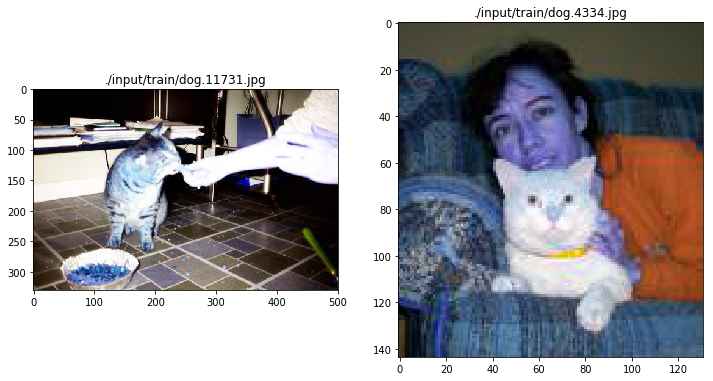

In [7]:
# 展示两张打错标签的图片

wrong_label_list = ['./input/train/dog.11731.jpg', './input/train/dog.4334.jpg']

def random_show(location):
    plt.subplot(location)
    sample = random.choice(wrong_label_list)
    image = cv2.imread(sample)
    plt.title(sample)
    plt.imshow(image)

plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)

plt.subplot(121)
image = cv2.imread(wrong_label_list[0])
plt.title(wrong_label_list[0])
plt.imshow(image)
    
plt.subplot(122)
image = cv2.imread(wrong_label_list[1])
plt.title(wrong_label_list[1])
plt.imshow(image)

plt.show()

In [3]:
# 删除打错标签的两张图片

wrong_label_list = ['./input/train/dog.11731.jpg', './input/train/dog.4334.jpg']

for file in train_images_path:
    if file in wrong_label_list:
        train_images_path.remove(file)
        print(file)

In [8]:
# 以直方图展示图片的宽高分布——kaggle训练集

height = []
width = []

for file in train_images_path:
    image = cv2.imread(file)
    height.append(image.shape[0])
    width.append(image.shape[1])
    
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
plt.subplot(121)
plt.hist(height)
plt.title("height distribution")

plt.subplot(122)
plt.hist(width)
plt.title("width distribution")

plt.show()

print('median of height: {}'.format(np.median(height)))
print('median of width: {}'.format(np.median(width)))

KeyboardInterrupt: 

./input/images/cat_5597.jpg
./input/images/cat_1399.jpg
./input/images/cat_4197.jpg
./input/images/cat_5760.jpg
./input/images/cat_7252.jpg
./input/images/cat_2717.jpg


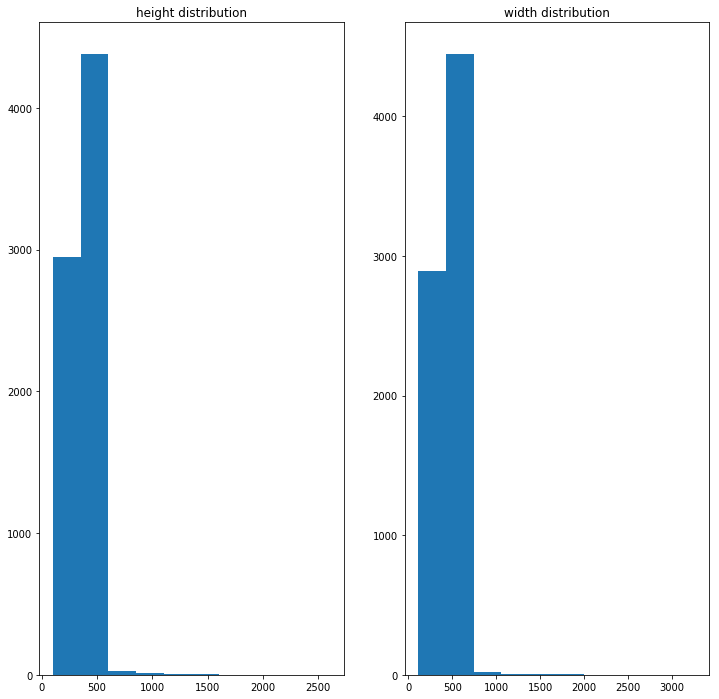

median of height: 375.0
median of width: 500.0


In [14]:
# 以直方图展示图片的宽高分布——补充训练集

TRAIN_DIR_SUP = './input/images/'
train_images_path_sup = [TRAIN_DIR_SUP+i for i in os.listdir(TRAIN_DIR_SUP)] 

height = []
width = []

none_img_list=[]

for file in train_images_path_sup:
    image = cv2.imread(file)
    if np.any(image != None):
        height.append(image.shape[0])
        width.append(image.shape[1])
    else:
        none_img_list.append(file)
        print(file)
        
plt.figure(figsize=(8,8))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
    
plt.subplot(121)
plt.hist(height)
plt.title("height distribution")

plt.subplot(122)
plt.hist(width)
plt.title("width distribution")

plt.show()

print('median of height: {}'.format(np.median(height)))
print('median of width: {}'.format(np.median(width)))

In [ ]:
# 随机展示9张补充集图片

def random_show(location):
    plt.subplot(location)
    sample = random.choice(train_images_path_sup)
    image = cv2.imread(sample)
    plt.title(sample)
    plt.imshow(image)
    
plt.figure(figsize=(12,12))
plt.subplots_adjust(wspace=0.2, hspace=0.2)
for location in range(331, 340):
    random_show(location)
plt.show()

In [4]:
# 数据融合

TRAIN_DIR_SUP = './input/images/'
train_images_path_sup = [TRAIN_DIR_SUP+i for i in os.listdir(TRAIN_DIR_SUP)] 

# height = []
# width = []

none_img_list=[]

for file in train_images_path_sup:
    image = cv2.imread(file)
    if np.any(image == None):
        none_img_list.append(file)
        print(file)

# 删除补充集无法读取的图片
for file in train_images_path_sup:
    if file in none_img_list:
        train_images_path_sup.remove(file)

# for path in tqdm(train_images_path_sup):
#     train_images_path.append(path)

len(train_images_path_sup)

KeyboardInterrupt: 

In [5]:
img = cv2.imread('./input/train/cat.123.jpg', cv2.IMREAD_COLOR)

In [6]:
img.shape

(272, 345, 3)

<function matplotlib.pyplot.show(*args, **kw)>

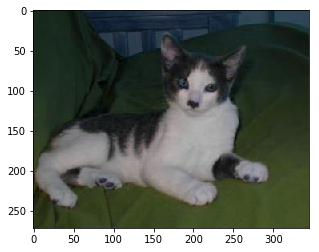

In [7]:
plt.imshow(img)
plt.show

In [10]:
imgt = img.transpose((1,0,2))

<function matplotlib.pyplot.show(*args, **kw)>

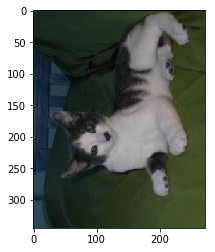

In [11]:
plt.imshow(imgt)
plt.show

In [12]:
imgt.shape

(345, 272, 3)

In [13]:
# 数据预处理


# 对训练集数据做乱序处理
random.shuffle(train_images_path)


def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC) # 对训练图片做缩放处理

def prep_train_data(images_path):
    
    # 对labels进行独热编码
    labels = np.zeros((len(images_path), 2), dtype=np.uint8)
    
    for i, path in enumerate(images_path):
        if 'dog' in path:
            labels[i][0] = 1
        else:
            labels[i][1] = 1
    
    count = len(images_path)
    features = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in enumerate(images_path):
        image = read_image(image_file)
        image.transpose((1,0,2))
        features[i] = image
        if i%2500 == 0: print('Processed {} of {}'.format(i, count))

    #features = data.transpose(0,2,3,1)

    return features, labels


features, labels = prep_train_data(train_images_path)

print("features shape: {}".format(features.shape))
print("labels shape: {}".format(labels.shape))

Processed 0 of 32384
Processed 2500 of 32384
Processed 5000 of 32384
Processed 7500 of 32384
Processed 10000 of 32384
Processed 12500 of 32384
Processed 15000 of 32384
Processed 17500 of 32384
Processed 20000 of 32384
Processed 22500 of 32384
Processed 25000 of 32384
Processed 27500 of 32384
Processed 30000 of 32384
features shape: (32384, 350, 350, 3)
labels shape: (32384, 2)


In [ ]:
pickle.dump((features, labels), open('train_data_batch.p', 'wb'))
print('save data done!')

In [ ]:
pickle.dump((features, labels), open('train_data.p', 'wb'))
print('save data done!')

In [ ]:
features, labels = pickle.load(open('train_data_batch.p', mode='rb'))
print('load data done!')

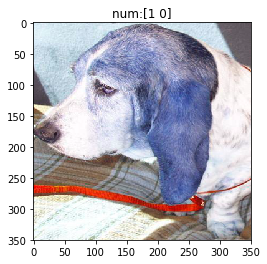

In [14]:
plt.imshow(features[1000])
plt.title('num:{}'.format(labels[1000]))
plt.show()

In [ ]:
# vgg16

base_model = VGG16(weights='imagenet', include_top=False, pooling='max')


# optimizer = RMSprop(lr=1e-4)
# optimizer = SGD(lr=0.005)
optimizer = Nadam(lr=0.0001)
objective = 'binary_crossentropy'

x = base_model.output
#x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)

outputs = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

#model.summary()

In [30]:
# VGG16 with ELU

from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU, ELU

#optimizer = RMSprop(lr=1e-4)
# optimizer = SGD
optimizer = Nadam(lr=0.0005)
objective = 'binary_crossentropy'

base_model = VGG16(include_top=False, weights='imagenet')

for layer in base_model.layers:
            layer.trainable = False
      
head = base_model.output
batchnormed_1 = BatchNormalization(axis=3)(head)
avgpooled = GlobalAveragePooling2D()(batchnormed_1)
dense = Dense(256)(avgpooled)
batchnormed_2 = BatchNormalization()(dense)
relu = ELU()(batchnormed_2)
dropout = Dropout(0.2)(relu)
output = Dense(2, activation='sigmoid')(dropout)
model = Model(base_model.input, output)


model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])

KeyboardInterrupt: 

In [ ]:
# ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, pooling='max')


#optimizer = RMSprop(lr=1e-4)
# optimizer = SGD
optimizer = Nadam(lr=0.0001)
objective = 'binary_crossentropy'

x = base_model.output
#x = Flatten()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
#x = Dense(64, activation='relu')(x)
#x = Dropout(0.5)(x)

outputs = Dense(2, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=outputs)

for layer in base_model.layers:
    layer.trainable = False

model.compile(loss=objective, optimizer=optimizer, metrics=['accuracy'])

# print(model.summary)
#model.summary()

In [15]:
# ResNet50 with PReLU

from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU, ELU

#optimizer = RMSprop(lr=1e-4)
# optimizer = SGD
optimizer = Nadam(lr=0.001)
objective = 'binary_crossentropy'

base_model = ResNet50(include_top=False, weights='imagenet')
        
head = base_model.output
batchnormed_1 = BatchNormalization(axis=3)(head)
avgpooled = GlobalAveragePooling2D()(batchnormed_1)
dense = Dense(256)(avgpooled)
batchnormed_2 = BatchNormalization()(dense)
relu = PReLU()(batchnormed_2)
dropout = Dropout(0.2)(relu)
output = Dense(2, activation='sigmoid')(dropout)
model = Model(base_model.input, output)

for layer in base_model.layers:
            layer.trainable = False

model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])

In [146]:
# ResNet50 with ELU

from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU, ELU

# optimizer = RMSprop(lr=1e-4)
# optimizer=SGD(0.001, momentum=0.9, nesterov=True)
# optimizer = SGD
optimizer = Nadam(lr=0.0005)
objective = 'binary_crossentropy'

base_model = ResNet50(include_top=False, weights='imagenet')

for layer in base_model.layers:
            layer.trainable = False


head = base_model.output
batchnormed_1 = BatchNormalization(axis=3)(head)
avgpooled = GlobalAveragePooling2D()(batchnormed_1)
dense = Dense(256)(avgpooled)
batchnormed_2 = BatchNormalization()(dense)
relu = ELU()(batchnormed_2)
dropout = Dropout(0.2)(relu)

# dense = Dense(256)(dropout)
# batchnormed_2 = BatchNormalization()(dense)
# relu = ELU()(batchnormed_2)
# dropout = Dropout(0.2)(relu)

output = Dense(1, activation='sigmoid')(dropout)
model = Model(base_model.input, output)


model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])

In [147]:
# 模型训练

nb_epoch = 20

val_checkpoint = ModelCheckpoint('resnet_bestval_{val_loss:.4f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# cur_checkpoint = ModelCheckpoint('current.h5')
    
lrSchduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min')


        
def run_catdog():
    
    history = LossHistory()
    model.fit_generator(train_generator,epochs=nb_epoch,verbose=1,validation_data=validation_generator, 
                        callbacks=[history, early_stopping, val_checkpoint,lrSchduler])
    
    return history

history = run_catdog()

Epoch 1/20
825/825 [==============================] - 931s 1s/step - loss: 0.0998 - acc: 0.9606 - val_loss: 0.0838 - val_acc: 0.9675

Epoch 00001: val_loss improved from inf to 0.08375, saving model to resnet_bestval_0.0838.h5
Epoch 2/20
 71/825 [=>............................] - ETA: 9:46 - loss: 0.0850 - acc: 0.9681

KeyboardInterrupt: 

In [117]:
def prep_data(images, img_height1, img_width1, inception=False):
    batches = [images[i:min(len(images), i + mini_batch_sz)] for i in range(0, len(images), mini_batch_sz)]
    for mini_batch in batches:
        data = np.ndarray((len(mini_batch), img_height1, img_width1, 3), dtype=np.float32)
        for i, image_file in enumerate(mini_batch):
            data[i] = np.asarray(Image.open(image_file).convert('RGB').resize((img_height1, img_width1)), dtype=np.float32)
            if inception:
                data[i] = np.divide(data[i], 255.0)
                data[i] = np.subtract(data[i], 1.0)
                data[i] = np.multiply(data[i], 2.0)
        yield data

In [111]:
def dog_probab(y):
    return [x[0] for x in y]

In [119]:
from PIL import Image, ImageEnhance, ImageFilter

mini_batch_sz = 16

test_images = ['./data/test/'+path for path in os.listdir('./data/test/')]
X = prep_data(test_images, 350, 350, inception=False)
dog_probabs = []
for mini_batch in X:
    y = dog_probab(model.predict(mini_batch))
    dog_probabs.extend(y)

In [121]:
len(dog_probabs)

1000

In [55]:
# ResNet50 和 VGG16 融合

from keras.layers.normalization import BatchNormalization
from keras.layers import GlobalAveragePooling2D
from keras.layers.advanced_activations import PReLU, ELU

#optimizer = RMSprop(lr=1e-4)
# optimizer = SGD(0.001, momentum=0.9, nesterov=True)
optimizer = Nadam(lr=0.0005)
objective = 'binary_crossentropy'

base_model_1 = VGG16(include_top=False, weights='imagenet')
base_model_2 = ResNet50(include_top=False, weights='imagenet')

for layer in base_model_1.layers:
    layer.trainable = False
        
for layer in base_model_2.layers:
    layer.trainable = False


head_1 = base_model_1.output
batchnormed_1 = BatchNormalization(axis=3)(head_1)
avgpooled_1 = GlobalAveragePooling2D()(batchnormed_1)

head_2 = base_model_2.output
batchnormed_2 = BatchNormalization(axis=3)(head_2)
avgpooled_2 = GlobalAveragePooling2D()(batchnormed_2)

multiscaleInputBlock = layers.Concatenate(axis=1)([avgpooled_1, avgpooled_2])


dense = Dense(256)(multiscaleInputBlock)
batchnormed_3 = BatchNormalization()(dense)
relu = ELU()(batchnormed_3)
dropout = Dropout(0.2)(relu)
output = Dense(2, activation='sigmoid')(dropout)

model = Model(input=[base_model_1.input, base_model_2.input], output=output)


model.compile(optimizer=optimizer, loss=objective, metrics=['accuracy'])

/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:39: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=[<tf.Tenso..., outputs=Tensor("de...)`


In [54]:
# 模型训练

nb_epoch = 20
batch_size = 128

val_checkpoint = ModelCheckpoint('resnet_bestval_{val_loss:.4f}.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')
# cur_checkpoint = ModelCheckpoint('current.h5')
    
lrSchduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

early_stopping = EarlyStopping(monitor='val_loss', patience=6, verbose=1, mode='min')


        
def run_catdog():
    
    history = LossHistory()
    model.fit(features, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.2, verbose=1, shuffle=True, callbacks=[history, early_stopping, val_checkpoint,lrSchduler])
    
    return history

history = run_catdog()

Train on 25907 samples, validate on 6477 samples
Epoch 1/20
25907/25907 [==============================] - 142s 5ms/step - loss: 0.0582 - acc: 0.9783 - val_loss: 0.0412 - val_acc: 0.9856

Epoch 00001: val_loss improved from inf to 0.04117, saving model to resnet_bestval_0.0412.h5
Epoch 2/20
25907/25907 [==============================] - 126s 5ms/step - loss: 0.0270 - acc: 0.9902 - val_loss: 0.0335 - val_acc: 0.9880

Epoch 00002: val_loss improved from 0.04117 to 0.03355, saving model to resnet_bestval_0.0335.h5
Epoch 3/20
25907/25907 [==============================] - 126s 5ms/step - loss: 0.0200 - acc: 0.9932 - val_loss: 0.0483 - val_acc: 0.9828

Epoch 00003: val_loss did not improve from 0.03355
Epoch 4/20
25907/25907 [==============================] - 126s 5ms/step - loss: 0.0164 - acc: 0.9943 - val_loss: 0.0395 - val_acc: 0.9870

Epoch 00004: val_loss did not improve from 0.03355

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
Epoch 5/20
25907/25907

In [17]:
model.save('my_model_nesnet_ 0356.h5')

In [ ]:
# 模型训练

nb_epoch = 100
batch_size = 128

# val_checkpoint = ModelCheckpoint('bestval.h5', 'val_loss', 1, True)
# cur_checkpoint = ModelCheckpoint('current.h5')
    
lrSchduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=2, cooldown=1, verbose=1)

## Callback for loss logging per epoch
class LossHistory(Callback):
    def on_train_begin(self, logs={}):
        self.losses = []
        self.val_losses = []
        
    def on_epoch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))

# early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, mode='auto')


        
def run_catdog():
    
    history = LossHistory()
    model.fit(features, labels, batch_size=batch_size, epochs=nb_epoch,
              validation_split=0.25, verbose=1, shuffle=True, callbacks=[history,lrSchduler])
    
    return history

history = run_catdog()

In [85]:
ROWS = 350
COLS = 350
CHANNELS = 3

TEST_DIR = './input/test/'

filenames = os.listdir(TEST_DIR)
filenames.sort(key=lambda x:int(x[:-4])) # 按文件名大小顺序排列

test_images_path =  [TEST_DIR+i for i in filenames]


test_images_path[:10]

['./input/test/1.jpg',
 './input/test/2.jpg',
 './input/test/3.jpg',
 './input/test/4.jpg',
 './input/test/5.jpg',
 './input/test/6.jpg',
 './input/test/7.jpg',
 './input/test/8.jpg',
 './input/test/9.jpg',
 './input/test/10.jpg']

In [9]:
# 利用预训练模型进行测试图片预处理

from keras.preprocessing.image import load_img, img_to_array

for file in tqdm(test_images_path):
    img = load_img(file) 
    x = img_to_array(img) 
 
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = base_model.predict(x)

100%|██████████| 12500/12500 [09:40<00:00, 21.55it/s]


In [11]:
# 保存测试集数据

pickle.dump(features, open('test_features.p', 'wb'))
print('save data done!')

save data done!


In [86]:
def read_image(file_path):
    img = cv2.imread(file_path, cv2.IMREAD_COLOR) #cv2.IMREAD_GRAYSCALE
    return cv2.resize(img, (ROWS, COLS), interpolation=cv2.INTER_CUBIC)

def prep_test_data(images_path):
    count = len(images_path)
    test_images = np.ndarray((count, ROWS, COLS, CHANNELS), dtype=np.uint8)

    for i, image_file in tqdm(enumerate(images_path)):
        image = read_image(image_file)
        image.transpose(1,0,2)
        test_images[i] = image
        # if i%2500 == 0: print('Processed {} of {}'.format(i, count))

#     test_images = data.transpose(0,2,3,1)

    return test_images

test_images = prep_test_data(test_images_path)

12500it [02:58, 69.87it/s]


In [14]:
test_images = pickle.load(open('test_data_350.p', mode='rb'))
print('load data done!')

EOFError: Ran out of input

3532it [00:40, 88.30it/s] 

In [ ]:
# 保存测试集数据

pickle.dump(test_images, open('test_data_350.p', 'wb'))
print('save data done!')

In [87]:
model = load_model('bestval_0.0329.h5')

In [88]:
predictions = model.predict(test_images,batch_size=128, verbose=1)

12500/12500 [==============================] - 311s 25ms/step


In [89]:
pickle.dump(predictions, open('predictions_single_0.0329.p', 'wb'))
print('save data done!')

save data done!


In [ ]:
for i in np.random.randint(low=0,high=12500,size=5):
    if predictions[i, 0] >= 0.5: 
        print('I am {:.2%} sure this is a Dog'.format(predictions[i][0]))
    else: 
        print('I am {:.2%} sure this is a Cat'.format(1-predictions[i][0]))
        
    plt.imshow(test_images[i])
    plt.show()

In [50]:
with open('submission15.csv','w') as f:
    f.write('id,label\n')
            
with open('submission15.csv','a') as f:
    num = len(predictions)
    pred = 0
    
    for i in tqdm(range(0,num)):
        pred = predictions[i, 0]
        
        f.write('{},{}\n'.format(i+1, pred))
        
f.close()
print('file closed!')

100%|██████████| 12500/12500 [00:00<00:00, 324345.32it/s]

file closed!
